In [2]:
import numpy as np
import tensorflow as tf
import pickle
import scipy.io
import idx2numpy
import random
from matplotlib import pyplot as plt

In [22]:
import math

In [23]:
train = scipy.io.loadmat('mnist_default_train_28x28.mat')
test = scipy.io.loadmat('mnist_default_test_28x28.mat')

In [24]:
train_labels = train['y']
train_data = train['X']

test_labels = test['y']
test_data = test['X']

In [25]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

((60000, 28, 28, 1), (60000, 10))
((10000, 28, 28, 1), (10000, 10))


In [26]:
print(train_labels[0])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [27]:
from matplotlib import pyplot as plt
def plot_img(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.show()

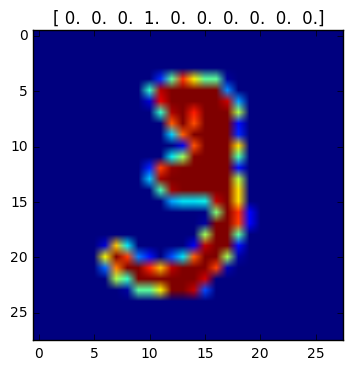

In [43]:
plot_img(train_data[10,:,:,0], train_labels[10])

In [44]:
WIDTH = 28

graph = tf.Graph()

with graph.as_default():
    X = tf.placeholder(tf.float32, [None, WIDTH, WIDTH, 1])
    Y_ = tf.placeholder(tf.float32, [None, 10])
    
    # Learning Rate - alpha
    alpha = tf.placeholder(tf.float32)
    
    # Dropout Probablity
    pkeep = tf.placeholder(tf.float32)
    
    # 5 Layers and their no of neurons
    # 3 Convolutional Layers and a fully connected layer
    K = 6     # First Conv Layer with depth 4
    L = 12     # Second Conv Layer with depth 8
    M = 24    # Third Conv layer with depth 12
    N = 200   # Fully Connected layer with 200 neurons
    # Last one will be softmax layer with 10 output channels
    
    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))     # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))
    
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    
    W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))
    
    # Model
    stride = 1  # output is 28x28
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    
    stride = 2  # output is 14x14
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    
    stride = 2  # output is 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
    YY4 = tf.nn.dropout(Y4, pkeep)
    
    Ylogits = tf.matmul(YY4, W5) + B5
    
    Y = tf.nn.softmax(Ylogits)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_)
    cross_entropy = tf.reduce_mean(cross_entropy)*100

    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)
    
    model_saver = tf.train.Saver()

In [45]:
num_steps = 20001
batch_size = 64

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    
    for step in range(num_steps):
        #  learning rate decay
        max_learning_rate = 0.003
        min_learning_rate = 0.0001
        decay_speed = 2000.0
        learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-step/decay_speed)

        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        
        feed_dict = {X : batch_data, Y_ : batch_labels, pkeep : 0.80, alpha : learning_rate}
        _, l, predictions = session.run([train_step, cross_entropy, accuracy], feed_dict=feed_dict)

        if (step % 500 == 0): 
            print('Loss at step %d: %f' % (step, l))
            print('accuracy : ', predictions )
            print('Learning rate : ', learning_rate)
            print('    ')
    
    _, l, predictions = session.run([train_step, cross_entropy, accuracy], feed_dict={X : test_data, Y_ : test_labels, pkeep : 1.0, alpha : 0.002})
    print('Test accuracy: ', predictions)
    
    save_path = model_saver.save(session, "CNN_MNIST_DEFAULT.ckpt")
    print("Model saved in file: %s" % save_path)

Initialized
Loss at step 0: 18286.910156
('accuracy : ', 0.125)
('Learning rate : ', 0.003)
    
Loss at step 500: 35.015774
('accuracy : ', 0.921875)
('Learning rate : ', 0.002358522270907074)
    
Loss at step 1000: 6.464936
('accuracy : ', 0.96875)
('Learning rate : ', 0.0018589389131666372)
    
Loss at step 1500: 23.385118
('accuracy : ', 0.921875)
('Learning rate : ', 0.0014698630029489428)
    
Loss at step 2000: 2.009192
('accuracy : ', 1.0)
('Learning rate : ', 0.0011668503793971828)
    
Loss at step 2500: 7.030925
('accuracy : ', 0.984375)
('Learning rate : ', 0.0009308639108945514)
    
Loss at step 3000: 0.580041
('accuracy : ', 1.0)
('Learning rate : ', 0.0007470774644304465)
    
Loss at step 3500: 1.592019
('accuracy : ', 1.0)
('Learning rate : ', 0.000603944436006291)
    
Loss at step 4000: 0.422044
('accuracy : ', 1.0)
('Learning rate : ', 0.0004924723213861769)
    
Loss at step 4500: 0.540502
('accuracy : ', 1.0)
('Learning rate : ', 0.00040565775122940656)
    
Lo

In [46]:
WIDTH = 28

grapha = tf.Graph()

with grapha.as_default():
    X = tf.placeholder(tf.float32, [None, WIDTH, WIDTH, 1])
    Y_ = tf.placeholder(tf.float32, [None, 10])
    
    # Learning Rate - alpha
    alpha = tf.placeholder(tf.float32)
    
    # Dropout Probablity
    pkeep = tf.placeholder(tf.float32)
    
    # 5 Layers and their no of neurons
    # 3 Convolutional Layers and a fully connected layer
    K = 6     # First Conv Layer with depth 4
    L = 12     # Second Conv Layer with depth 8
    M = 24    # Third Conv layer with depth 12
    N = 200   # Fully Connected layer with 200 neurons
    # Last one will be softmax layer with 10 output channels
    
    W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))     # 6x6 patch, 1 input channel, K output channels
    B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
    
    W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
    B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
    
    W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
    B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))
    
    W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
    B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
    
    W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
    B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))
    
    # Model
    stride = 1  # output is 28x28
    Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
    
    stride = 2  # output is 14x14
    Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
    
    stride = 2  # output is 7x7
    Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

    # reshape the output from the third convolution for the fully connected layer
    YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

    Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
    YY4 = tf.nn.dropout(Y4, pkeep)
    
    Ylogits = tf.matmul(YY4, W5) + B5
    
    Y = tf.nn.softmax(Ylogits)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(Ylogits, Y_)
    cross_entropy = tf.reduce_mean(cross_entropy)*100

    # accuracy of the trained model, between 0 (worst) and 1 (best)
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    pred = tf.reduce_mean(tf.cast(tf.argmax(Y, 1), tf.float32))
    
    train_step = tf.train.AdamOptimizer(alpha).minimize(cross_entropy)
    
    model_saver = tf.train.Saver()

In [47]:
from PIL import Image
img_name = ['1', '0']
tags = np.array([[0.,1.,0.,0.,0.,0.,0.,0.,0.,0.],[1.,0.,0.,0.,0.,0.,0.,0.,0.,0.]])

In [48]:
images_ = []
for img in img_name :
    n = '_' + img + '_.jpg'
    images_.append(Image.open(n).convert('L'))
    
for img in images_ :
    img = img.convert('L')
    
images_array_ = []
for i in images_ :
    images_array_.append(np.array(i))
    
for i in range(len(images_array_)) :
    images_array_[i] = images_array_[i][:,:,np.newaxis]
    
images_array_ = np.array(images_array_)

images_array_ = (images_array_.astype(np.float32))
tags = (tags.astype(np.int32))

print(images_array_.shape, tags.shape)

((2, 28, 28, 1), (2, 10))


In [49]:
with tf.Session(graph=grapha) as session:
#     tf.initialize_all_variables().run()
    model_saver.restore(session, "CNN_MNIST_DEFAULT.ckpt")
    print("Model restored.") 
    print('Initialized')
    
    predictions, y, p = session.run([accuracy, Y, pred], feed_dict={X : images_array_, Y_ : tags, pkeep : 1.0, alpha : 0.002})
    print(predictions)
    print(np.argmax(y[0]), np.argmax(y[1]))
    print(tags)
    print('Test accuracy: ', predictions)


Model restored.
Initialized
0.0
(5, 5)
[[0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
('Test accuracy: ', 0.0)
